# Project 1: Exploratory Data Analysis of Movies
Amelia Dahm & Khyatee Desai

## Inspecting all the files

1. bom.movie_gross.csv.gz
2. imdb.title.ratings.csv.gz
3. imdb.name.basics.csv.gz
4. rt.movie_info.tsv.gz
5. imdb.title.akas.csv.gz
6. rt.reviews.tsv.gz
7. imdb.title.basics.csv.gz
8. tmdb.movies.csv.gz
9. imdb.title.crew.csv.gz
10. tn.movie_budgets.csv.gz
11. imdb.title.principals.csv.gz

In [180]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
%matplotlib inline

## movie gross - Table 1

In [297]:

movie_gross_raw = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
movie_gross_raw

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


## IMDB ratings - Table 2

In [294]:
imdb_raw = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
imdb_raw

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


## name basics - Table 3

In [288]:
name_basics_raw = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
name_basics_raw

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


## movie info - Table 4

In [287]:
movie_info_raw = pd.read_csv('./zippedData/rt.movie_info.tsv.gz',sep='\t')
movie_info_raw

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


## movie titles - Table 5

In [286]:
titles_raw = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
titles_raw


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,NaN,NaN,original,NaN,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,NaN,0.0
331700,tt9880178,1,La atención,NaN,NaN,original,NaN,1.0
331701,tt9880178,2,La atención,ES,NaN,NaN,NaN,0.0


## RT reviews - Table 6

In [285]:
rt_raw = pd.read_csv('./zippedData/rt.reviews.tsv.gz',sep='\t', encoding = "ISO-8859-1")
rt_raw

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


## Movie Genres/Runtime - Table 7

In [284]:
genre_raw = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
genre_raw

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


## TMDB Ratings - Table 8

In [283]:
tmdb_raw = pd.read_csv('./zippedData/tmdb.movies.csv.gz')
tmdb_raw

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


## Directors/Writers - Table 9

In [282]:
crew_raw = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
crew_raw

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943
...,...,...,...
146139,tt8999974,nm10122357,nm10122357
146140,tt9001390,nm6711477,nm6711477
146141,tt9001494,"nm10123242,nm10123248",NaN
146142,tt9004986,nm4993825,nm4993825


## ROI - Table 10

In [338]:
budgets_raw = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')
budgets_raw

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


## Actors & Characters - Table 11

In [280]:
characters_raw = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
characters_raw

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,NaN,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,NaN,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,NaN,NaN
1028184,tt9692684,4,nm6009913,writer,writer,NaN


# Question 1: The People vs the Academy
### Why is this relevant to Microsoft?
What are the commonalities among award-nominated movies?<br>
- genre
- actors
- budget

<br>Do better online ratings = more awards?<br>

**Maybe look at demographics? Black actors, female actors etc<br>
### Datasets:
- https://www.kaggle.com/unanimad/the-oscar-award
- https://www.kaggle.com/fmejia21/demographics-of-academy-awards-oscars-winners?select=Oscars-demographics-DFE.csv

## Raw Oscar Data - Table 12

In [300]:
oscars_raw = pd.read_csv('./zippedData/oscars.zip', encoding = "ISO-8859-1")
oscars_raw

,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
2,1927,1928,1,ACTRESS,Louise Dresser,A Ship Comes In,False
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
4,1927,1928,1,ACTRESS,Gloria Swanson,Sadie Thompson,False
...,...,...,...,...,...,...,...
10390,2019,2020,92,WRITING (Original Screenplay),"Screenplay by Bong Joon Ho, Han Jin Won; Story...",Parasite,True
10391,2019,2020,92,JEAN HERSHOLT HUMANITARIAN AWARD,Geena Davis,NaN,True
10392,2019,2020,92,HONORARY AWARD,David Lynch,NaN,True
10393,2019,2020,92,HONORARY AWARD,Wes Studi,NaN,True


## TMDB Merge

In [292]:
# Rename columns to specify TMDB, and subset data to only get columns of interest
tmdb = tmdb_raw.merge(movie_gross[['title', 'domestic_gross', 'foreign_gross']], on='title', how='left')
tmdb.rename(columns ={'popularity':'tmdb_popularity', 'vote_average': 'tmdb_rating', 'vote_count': 'tmdb_votes'}, inplace=True)
tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,tmdb_popularity,release_date,title,tmdb_rating,tmdb_votes,domestic_gross,foreign_gross
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,NaN,NaN
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,217600000.0,277300000
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,312400000.0,311500000
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,NaN,NaN
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,292600000.0,535700000
...,...,...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1,NaN,NaN
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,NaN,NaN
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1,NaN,NaN
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,NaN,NaN


## Rotten Tomatoes Merge

In [290]:
# Rename columns to specify Rotten Tomatoes, and subset data to only get columns of interest
rt_raw.rename(columns={'review':'rt_review', 'rating':'rt_rating'}, inplace=True)
rt = rt_raw[['id', 'rt_review', 'rt_rating', 'fresh']]


In [291]:
#losing a ton of data by merging to get titles names for our rotten tomatoes data but...oh well
rt.merge(tmdb[['id','original_title', 'title']], on='id')

,id,rt_review,rt_rating,fresh,original_title,title
0,93,This is the cinema's lightest and sharpest app...,NaN,fresh,Anatomy of a Murder,Anatomy of a Murder
1,93,"This is not merely a Garbo film, it is a Lubit...",NaN,fresh,Anatomy of a Murder,Anatomy of a Murder
2,93,"The romantic roundelay, linking fine emotions ...",NaN,fresh,Anatomy of a Murder,Anatomy of a Murder
3,93,This column has generally no quarrel with scen...,NaN,rotten,Anatomy of a Murder,Anatomy of a Murder
4,93,This one is neither crude clowning nor crude p...,NaN,fresh,Anatomy of a Murder,Anatomy of a Murder
...,...,...,...,...,...,...
1055,1930,Second and least successful entry in the Harry...,3/5,fresh,The Amazing Spider-Man,The Amazing Spider-Man
1056,1930,NaN,2/5,rotten,The Amazing Spider-Man,The Amazing Spider-Man
1057,1930,NaN,3/5,fresh,The Amazing Spider-Man,The Amazing Spider-Man
1058,1930,NaN,7,fresh,The Amazing Spider-Man,The Amazing Spider-Man


## IMDB Merge

In [298]:
# To retain as much info as possible, joined imdb_ratings with title table rather than title_basics
imdb_merge = imdb_raw.merge(title,left_on ='tconst', right_on ='title_id')
imdb_merge = imdb_merge.merge(movie_gross_raw[['title', 'domestic_gross', 'foreign_gross']], on='title', how='left')
imdb_merge.rename(columns ={'averagerating':'imdb_rating', 'numvotes': 'imdb_votes'}, inplace=True)

In [299]:
imdb_merge = imdb_merge[['title_id', 'title', 'imdb_rating', 'imdb_votes','domestic_gross', 'foreign_gross' ]]
imdb_merge

,title_id,title,imdb_rating,imdb_votes,domestic_gross,foreign_gross
0,tt1042974,Just Inès,6.4,20,NaN,NaN
1,tt1042974,Samo Ines,6.4,20,NaN,NaN
2,tt1042974,Just Inès,6.4,20,NaN,NaN
3,tt1043726,The Legend of Hercules,4.2,50352,18800000.0,42400000
4,tt1043726,Hércules - A Lenda Começa,4.2,50352,NaN,NaN
...,...,...,...,...,...,...
261804,tt9691896,Coming Out,6.3,21,NaN,NaN
261805,tt9844256,Code Geass: Lelouch of the Rebellion Episode III,7.5,24,NaN,NaN
261806,tt9844256,Code Geass: Lelouch of the Rebellion Episode III,7.5,24,NaN,NaN
261807,tt9844256,Code Geass: Lelouch of the Rebellion - Glorifi...,7.5,24,NaN,NaN


## Oscar Noms X Genre 

In [331]:

# subset the relevant data, rename columns, drop rows with no movie title
oscars = oscars_raw.loc[:,['film','name', 'category']]
oscars.rename(columns={'film': 'title', 'name': 'person'}, inplace=True)
oscars.drop(oscars[oscars['title'].isnull()].index, inplace=True)


# create column for total number of oscar nominations per movie
counts = oscars['title'].value_counts()
d = counts.to_dict()
oscars['oscar_noms'] = oscars['title'].map(d)


# join Oscars table with Genre, using 'original_title' to retain more rows
genre_subset = genre_raw.loc[:,[ 'original_title', 'genres']]
oscars = oscars.merge(genre_subset, how = 'left', left_on='title', right_on='original_title').drop('original_title', axis=1)
oscars

,title,person,category,oscar_noms,genres
0,The Noose,Richard Barthelmess,ACTOR,1,Documentary
1,The Last Command,Emil Jannings,ACTOR,2,NaN
2,A Ship Comes In,Louise Dresser,ACTRESS,1,NaN
3,7th Heaven,Janet Gaynor,ACTRESS,5,NaN
4,Sadie Thompson,Gloria Swanson,ACTRESS,1,NaN
...,...,...,...,...,...
11614,Knives Out,Written by Rian Johnson,WRITING (Original Screenplay),1,"Crime,Drama,Mystery"
11615,Marriage Story,Written by Noah Baumbach,WRITING (Original Screenplay),6,NaN
11616,1917,Written by Sam Mendes & Krysty Wilson-Cairns,WRITING (Original Screenplay),10,"Drama,War"
11617,Once upon a Time...in Hollywood,Written by Quentin Tarantino,WRITING (Original Screenplay),10,NaN


## Prep Movie Gross table

In [388]:
movie_gross = movie_gross_raw.loc[:, ['title', 'domestic_gross', 'foreign_gross']]
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['total_gross'] = movie_gross.domestic_gross + movie_gross.foreign_gross.astype(float)
movie_gross

,title,domestic_gross,foreign_gross,total_gross
0,Toy Story 3,415000000.0,652000000,1.067000e+09
1,Alice in Wonderland (2010),334200000.0,691300000,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,296000000.0,664300000,9.603000e+08
3,Inception,292600000.0,535700000,8.283000e+08
4,Shrek Forever After,238700000.0,513900000,7.526000e+08
...,...,...,...,...
3382,The Quake,6200.0,NaN,NaN
3383,Edward II (2018 re-release),4800.0,NaN,NaN
3384,El Pacto,2500.0,NaN,NaN
3385,The Swan,2400.0,NaN,NaN


 ## Prep Budgets table

In [385]:
budgets = budgets_raw.loc[:,['movie', 'production_budget', 'domestic_gross', 'worldwide_gross']]
budgets.rename(columns={'movie': 'title', 'worldwide_gross':'foreign_gross'}, inplace=True)
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','').astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','').astype(float)
budgets['foreign_gross'] = budgets['foreign_gross'].str.replace('$','')
budgets['foreign_gross'] = budgets['foreign_gross'].str.replace(',','').astype(float)

budgets['total_gross'] = budgets.domestic_gross + budgets.foreign_gross
budgets

,title,production_budget,domestic_gross,foreign_gross,total_gross
0,Avatar,425000000.0,760507625.0,2.776345e+09,3.536853e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,1.286728e+09
2,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,1.925247e+08
3,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,1.862020e+09
4,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,1.936903e+09
...,...,...,...,...,...
5777,Red 11,7000.0,0.0,0.000000e+00,0.000000e+00
5778,Following,6000.0,48482.0,2.404950e+05,2.889770e+05
5779,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03,2.676000e+03
5780,A Plague So Pleasant,1400.0,0.0,0.000000e+00,0.000000e+00


## Concat Movie Gross table X Budgets table

In [401]:
concat = pd.concat([movie_gross, budgets])
concat.drop_duplicates(subset=['title'],keep='last', inplace=True)
concat

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,domestic_gross,foreign_gross,production_budget,title,total_gross
1,334200000.0,691300000,NaN,Alice in Wonderland (2010),1.025500e+09
2,296000000.0,664300000,NaN,Harry Potter and the Deathly Hallows Part 1,9.603000e+08
10,163200000.0,330000000,NaN,Clash of the Titans (2010),4.932000e+08
12,135500000.0,275400000,NaN,The King's Speech,4.109000e+08
13,172100000.0,228000000,NaN,Tron Legacy,4.001000e+08
...,...,...,...,...,...
5777,0.0,0,7000.0,Red 11,0.000000e+00
5778,48482.0,240495,6000.0,Following,2.889770e+05
5779,1338.0,1338,5000.0,Return to the Land of Wonders,2.676000e+03
5780,0.0,0,1400.0,A Plague So Pleasant,0.000000e+00


# Oscar Nominations X Genre X Budget

In [336]:
# subset the oscars table, drop duplicate listings

genre = oscars.loc[:,['title', "oscar_noms", 'genres']]
# genre.dropna(subset=['genres'], inplace=True)
genre.drop_duplicates(inplace=True)

# join genre/oscar table with budgets.....



,title,oscar_noms,genres
0,The Noose,1,Documentary
1,The Last Command,2,NaN
2,A Ship Comes In,1,NaN
3,7th Heaven,5,NaN
4,Sadie Thompson,1,NaN
...,...,...,...
11579,A Sister,1,NaN
11589,Ad Astra,1,"Adventure,Drama,Mystery"
11598,Avengers: Endgame,1,"Action,Adventure,Sci-Fi"
11613,Knives Out,1,Drama


# Oscar Awards X TMDB Ratings - not sure if doing anything with this

In [205]:
# merge oscars df with TMDB ratings df
oscars_tmdb = oscars.merge(tmdb,how='right', left_on='film', right_on='title')

# create column for total number of oscar nominations per movie
counts = oscars_tmdb.original_title.value_counts()
d = counts.to_dict()
oscars_tmdb['nominations'] = oscars_tmdb['original_title'].map(d)

# subset important columns, drop duplicate rows, set movie title as index
oscars_tmdb = oscars_tmdb.sort_values('nominations', ascending=False)[['title','original_title','tmdb_popularity','tmdb_rating','tmdb_votes','nominations']].set_index('title').drop_duplicates()
oscars_tmdb

,original_title,tmdb_popularity,tmdb_rating,tmdb_votes,nominations
title,,,,,
La La Land,La La Land,16.275,7.9,10028,28
The Shape of Water,The Shape of Water,22.025,7.2,7224,26
A Star Is Born,A Star Is Born,35.848,7.5,5676,25
Milk,Milk,0.600,10.0,1,24
Milk,Milk,1.218,5.0,1,24
...,...,...,...,...,...
Terraferma,Terraferma,2.923,6.6,43,1
Triple Crossed,Triple Crossed,2.941,4.9,18,1
House of Good and Evil,House of Good and Evil,2.961,4.5,22,1


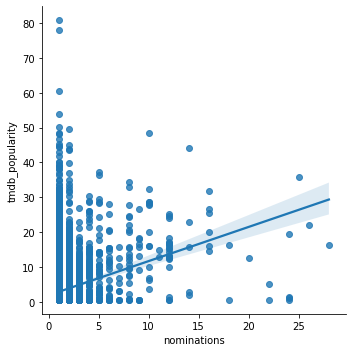

In [207]:
# data = sns.load_dataset('oscars_tmdb')
sns.lmplot('nominations', 'tmdb_popularity', data = oscars_tmdb)

# Question 2: Movie Music Scores
### Why is this relevant to Microsoft?
Is a good music score important?<br>
Do better movies tend to have better music scores?<br>
Which composers have the most successful music scores?<br>
### Datasets: 
- https://www.soundtrack.net/content/reviews/
- http://www.movie-wave.net/reviews-by-composer/
- https://www.filmtracks.com/reviews/a.html

# Question 3: Inflation